In [1]:
import jax.numpy as jnp
import pandas as pd
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pprint import pprint
# SKAI imports

# symbolic ODE solver from SKAI
from BI.utilities.reaction_solver import SymbolicRXNSolver

# bayesian inference from SKAI
from BI.models.Inference import BayesianKineticAI

C:\Users\MalakM02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# experimental data
df_raw = pd.read_csv("example_2_experimental_data2.csv")

# initial conditions
input_data_for_case_study_1 = pd.read_csv('Initial_conditions_example2.csv').to_dict(orient='list')
input_data_for_case_study_1.keys()

dict_keys(['T', 'SM', 'base', 'reagent', 'time'])

In [3]:
# Automated way to get initial conditions from file
inputdata = input_data_for_case_study_1

columns = list(inputdata.keys())

time_col = inputdata['time']

num_rows = len(time_col)

value_columns = [col for col in columns if col != 'time']
collected_rows = []

for i in range(num_rows):
    if time_col[i] == 0:
        row_values = [inputdata[col][i] for col in value_columns]
        # switching the last two columns because it breaks otherwise
        if len(row_values) >= 2:
            row_values[-2], row_values[-1] = row_values[-1], row_values[-2]
        collected_rows.append(row_values)


input_matrix = jnp.array(collected_rows).T
# print(input_matrix)

# X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
# X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
# X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
# X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
# X5 = jnp.array([71.0, 0.209, 0.2, 0.407])

# X1 = jnp.reshape(X1, (4, 1))
# X2 = jnp.reshape(X2, (4, 1))
# X3 = jnp.reshape(X3, (4, 1))
# X4 = jnp.reshape(X4, (4, 1))
# X5 = jnp.reshape(X5, (4, 1))

# input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)
print("Input matrix: ", input_matrix)

Input matrix:  [[81.9   81.9   81.9   61.1   71.   ]
 [ 0.208  0.203  0.204  0.209  0.209]
 [ 0.2    0.4    0.2    0.2    0.2  ]
 [ 0.405  0.405  0.811  0.406  0.407]]


In [4]:

# define the initial conditions
#
#                  # T  SM_0   R_0   B_0
# X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
# X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
# X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
# X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
# X5 = jnp.array([71.0, 0.209, 0.2, 0.407])
#
# X1 = jnp.reshape(X1, (4, 1))
# X2 = jnp.reshape(X2, (4, 1))
# X3 = jnp.reshape(X3, (4, 1))
# X4 = jnp.reshape(X4, (4, 1))
# X5 = jnp.reshape(X5, (4, 1))
#
# input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)

time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])
t = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 540.0, 900.0])


# ground_truth_params = {
# "k1_f": 0.011,
# "E1_f": 70.2E3,
# "k2_f": 0.002,
# "E2_f": 78.92E3,
# }

ground_truth_params = {
"k1_f": 0.1,
"E1_f": 70000,
"k2_f": 0.1,
"E2_f": 70000,
}

In [5]:
# Reading intial conditions and put them into a jnp array as the main input "X_measured"

T              = jnp.array(input_data_for_case_study_1['T'])
SM             = jnp.array(input_data_for_case_study_1['SM'])
reagent        = jnp.array(input_data_for_case_study_1['reagent'])
base           = jnp.array(input_data_for_case_study_1['base'])
time           = jnp.array(input_data_for_case_study_1['time'])


X_measured     = jnp.column_stack((T, SM, reagent, base, time))

In [6]:
# Preparing the experimental data and save them in a 1D array as y_exp_data
SM_measured = []
P_measured = []
IMP_measured = []

for i in range(0, 5):
    SM_measured.append(df_raw.iloc[:, i * 4 + 1])
    P_measured.append(df_raw.iloc[:, i * 4 + 2])
    IMP_measured.append(df_raw.iloc[:, i * 4 + 3])


non_nan_values_SM  = np.concatenate(SM_measured)
non_nan_values_P   = np.concatenate(P_measured)
non_nan_values_IMP = np.concatenate(IMP_measured)


# # Calculate the measured_Y_without_Nan using non-NaN values arrays   
# ******NOTE ******this is where we apply weighting factor
# measured_Y_without_Nan =  non_nan_values_P +  non_nan_values_IMP
measured_Y_without_Nan = 0.9* non_nan_values_P + 0.1*non_nan_values_SM + 0.1*non_nan_values_IMP
nan_mask = jnp.isnan(measured_Y_without_Nan)
y_without_nan = measured_Y_without_Nan[~nan_mask]

# adding noise
noise_level = 0.0001
noise = np.random.normal(0, noise_level, y_without_nan.shape)
y_exp_data = y_without_nan + noise
X_dummy = X_measured
Y_dummy = y_exp_data

In [7]:
# Load your CSV data into a DataFrame
df = pd.read_csv("res_case study 1.csv")

# Step 1: Get top 3 mechanisms per experiment
top_mechs = (
    df.sort_values(['Experiment #', 'Probability'], ascending=[True, False])
      .groupby('Experiment #')
      .head(3)
)

# Step 2: Sum probabilities across experiments
mech_avg = (
    top_mechs.groupby('Mechanism')['Probability']
             .mean()
             .sort_values(ascending=False)
)

# Step 3: Get the mechanism with the highest average probability
best_mechanism = mech_avg.idxmax()
best_avg_probability = mech_avg.max()

print("Best mechanism (by average probability in top 3):", best_mechanism)
print("Average probability per experiment:", round(best_avg_probability, 2))


Best mechanism (by average probability in top 3): SM + B + R -> P + B,  P + B + R -> IMP2 + B
Average probability per experiment: 0.23


In [ ]:
import re
from collections import defaultdict

def parse_species(species_str):
    """Parses 'SM + B + R' into {'SM':1, 'base':1, 'reagent':1} using symbolic aliases."""
    species = [s.strip() for s in species_str.split('+')]
    counts = defaultdict(int)
    for s in species:
        if s == 'R':
            s = 'Reagent'
        elif s == 'P':
            s = 'product'
        elif s == 'B':
            s = 'Base'
        elif s == 'SM':
            s = 'SM'
        elif s == 'INT1':
            s = 'INT1'
        elif re.fullmatch(r'IMP\d+', s):
            s = "IMP1"
        elif s == 'C':
            s = 'Catalyst'
        counts[s] = 1
    return dict(counts)

def mechanism_to_rxn_template(
        mechanism_str,
        SM_order, reagent_order, base_order,
        params
    ):
        reactions = [r.strip() for r in mechanism_str.split(',')]
        rxn_template = {}

        for i, reaction in enumerate(reactions):
            lhs, rhs = [side.strip() for side in reaction.split('->')]
            lhs_dict = parse_species(lhs)
            rhs_dict = parse_species(rhs)   

            # For some reason, base needs to be at the end of the dictionary or else everything breaks
            # Changing the order of 'reagent' and 'base' in the initial_species or all_species dictionary in reaction_solver
            # somehow breaks everything. Not entirely sure why
            base_value = lhs_dict.pop('Base', None)
            if base_value is not None:
                lhs_dict['Base'] = base_value
            # rhs_dict.pop('base', None)

            rxn_key = f'rxn{i+1}'
            k_f = params['k1_f'] if i == 0 else params['k2_f']
            E_f = params['E1_f'] if i == 0 else params['E2_f']

            rxn_orders_f = {}
            
            for species in lhs_dict:
                if species == "Reagent" and reagent_order != 0:
                    rxn_orders_f[species] = reagent_order
                elif species == "Base" and base_order != 0:
                    rxn_orders_f[species] = base_order
                elif species == "SM" and SM_order != 0:
                    rxn_orders_f[species] = SM_order
                elif species == "product" and rxn_key == "rxn2":
                    rxn_orders_f[species] = 1


            rxn_template[rxn_key] = {
                'reactants': lhs_dict,
                'products': rhs_dict,
                'k_f': k_f,
                'E_f': E_f,
                'reversible': False,
                'T_ref': 273.15 + 81.9,
                'Rxn_orders_f': rxn_orders_f,
                'Rxn_orders_b': '',
            }

        return rxn_template



# rxn_orders1 = {'SM': 1, 'reagent': 1}
# rxn_orders2 = {'product': 1, 'reagent': 1}
# rxns = mechanism_to_rxn_template(best_mechanism, 1, 1, 0)
rxns = mechanism_to_rxn_template(best_mechanism, 1, 1, 0, ground_truth_params)
# rxns = {
#     'rxn1': {
#         'reactants': {'SM': 1, 'reagent': 1, 'base':1},
#         'products': {'product': 1, 'base': 1},
#         'k_f': 0.1,
#         'E_f': 70000,
#         'reversible': False,  
#         'T_ref':273.15+81.9,
#         'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
#         'Rxn_orders_b': '',
#     },

#     'rxn2': {   
#         'reactants': {'product': 1, 'reagent': 1, 'base':1},
#         'products': {'IMP1': 1},
#         'k_f': 0.1,
#         'E_f': 70E3,
#         'reversible': False, 
#         'T_ref':273.15+81.9, 
#         'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
#         'Rxn_orders_b': '', 
        
#     }
# }
pprint(rxns)

{'rxn1': {'E_f': 70000,
          'Rxn_orders_b': '',
          'Rxn_orders_f': {'SM': 1, 'base': 1, 'reagent': 1},
          'T_ref': 355.04999999999995,
          'k_f': 0.1,
          'products': {'base': 1, 'product': 1},
          'reactants': {'SM': 1, 'base': 1, 'reagent': 1},
          'reversible': False},
 'rxn2': {'E_f': 70000.0,
          'Rxn_orders_b': '',
          'Rxn_orders_f': {'base': 1, 'product': 1, 'reagent': 1},
          'T_ref': 355.04999999999995,
          'k_f': 0.1,
          'products': {'IMP1': 1},
          'reactants': {'base': 1, 'product': 1, 'reagent': 1},
          'reversible': False}}


In [ ]:
rxns2 = mechanism_to_rxn_template("SM + B + R -> P + B,  SM + P + B -> IMP2 + B", 1, 1, 1, ground_truth_params)
# rxns2 = {
#     'rxn1': {
#         'reactants': {'SM': 1, 'reagent': 1, 'base':1},
#         'products': {'product': 1, 'base':1},
#         'k_f': 0.1,
#         'E_f': 70E3,
#         'reversible': False,  
#         'T_ref':273.15+81.9,
#         'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
#         'Rxn_orders_b': '',
#     },

#     'rxn2': {
#         'reactants': {'SM': 1, 'product': 1, 'base':1},
#         'products': {'IMP2': 1, 'base':1},
#         'k_f': 0.1,
#         'E_f': 70000,
#         'reversible': False, 
#         'T_ref':273.15+81.9, 
#         'Rxn_orders_f': {'SM':1, 'product': 1, 'base':1},
#         'Rxn_orders_b': '', 
        
#     }
# }

pprint(rxns2)

{'rxn1': {'E_f': 70000.0,
          'Rxn_orders_b': '',
          'Rxn_orders_f': {'SM': 1, 'base': 1, 'reagent': 1},
          'T_ref': 355.04999999999995,
          'k_f': 0.1,
          'products': {'base': 1, 'product': 1},
          'reactants': {'SM': 1, 'base': 1, 'reagent': 1},
          'reversible': False},
 'rxn2': {'E_f': 70000,
          'Rxn_orders_b': '',
          'Rxn_orders_f': {'SM': 1, 'base': 1, 'product': 1},
          'T_ref': 355.04999999999995,
          'k_f': 0.1,
          'products': {'IMP2': 1, 'base': 1},
          'reactants': {'SM': 1, 'base': 1, 'product': 1},
          'reversible': False}}


In [37]:
# reaction order check:
# base order change
reactions = [rxns, rxns2]

# reactions = [
# {
#     'rxn1': {
#         'reactants': {'SM': 1, 'reagent': 1, 'base':1},
#         'products': {'product': 1},
#         'k_f': 0.011,
#         'E_f': 70200,
#         'reversible': False,  
#         'T_ref':273.15+81.9,
#         'Rxn_orders_f': {'SM':1, 'reagent':1},
#         'Rxn_orders_b': '',
#     },

#     'rxn2': {   
#         'reactants': {'product': 1, 'reagent': 1, 'base':1},
#         'products': {'IMP1': 1},
#         'k_f': 0.002,
#         'E_f': 78920,
#         'reversible': False, 
#         'T_ref':273.15+81.9, 
#         'Rxn_orders_f': {'product':1, 'reagent': 1},
#         'Rxn_orders_b': '', 
        
#     }
# }
# ,

# {
#     'rxn1': {
#         'reactants': {'SM': 1, 'reagent': 1, 'base':1},
#         'products': {'product': 1},
#         'k_f': 0.01,
#         'E_f': 70E3,
#         'reversible': False,  
#         'T_ref':273.15+81.9,
#         'Rxn_orders_f': {'reagent':1}, 
#         'Rxn_orders_b': '',
#     },

#     'rxn2': {   
#         'reactants': {'product': 1, 'reagent': 1, 'base':1},
#         'products': {'IMP1': 1},
#         'k_f': 0.002,
#         'E_f': 78E3,
#         'reversible': False, 
#         'T_ref':273.15+81.9, 
#         'Rxn_orders_f': {'reagent': 1, 'product':1},
#         'Rxn_orders_b': '', 
        
#     }
# }
# ]

# initial_species = list(reactions[0]['rxn1']['reactants'].keys())
# reactions_list = []

# for i, reaction_data in enumerate(reactions, start=1):
#     reaction_solver = SymbolicRXNSolver(reaction_data)
#     reaction_solver.reaction_table()
#     reactions_list.append(reaction_solver)

initial_species = ["SM", "Base", "Reagent"]
reactions_list = []

for i, reaction_data in enumerate(reactions, start=1):
    reaction_solver = SymbolicRXNSolver(reaction_data)
    reaction_solver.reaction_table()
    reactions_list.append(reaction_solver)

pprint(rxns2)
# print(reactions[1])
# reactions_exp = reaction1_1.write_reaction_rate_expressions()
# for reaction_name in reactions_exp.items():
#     print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products         | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product + 1base | 0.1   | 70000   | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1            | 0.1   | 70000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
Reaction:

+----------+------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants              |     | Products         | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+------------------------+-----+-----------------

In [38]:
import math
def _new_priors2():
    k1_f = numpyro.sample("k1_f", dist.LogNormal(abs(math.log(0.1)), 1))
    E1_f = numpyro.sample("E1_f", dist.Normal(abs(math.log(70000)), 1))
    k2_f = numpyro.sample("k2_f", dist.LogNormal(abs(math.log(0.1)), 1))
    E2_f = numpyro.sample("E2_f", dist.Normal(abs(math.log(70000)), 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,  
            "E2_f": E2_f}


In [39]:
# def _new_priors3():
#     k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
#     E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
#     k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
#     E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
#     return {"k1_f": k1_f,
#             "E1_f": E1_f,
#             "k2_f": k2_f,
#             "E2_f": E2_f}


def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
    E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
    E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [40]:
# BI_reaction1 = BayesianKineticAI()
# BI_model = BI_reaction1.run_bayesian_inference(function = reaction1_1.simulate_symbolic_ode_for_numpyro,
#     priors = _new_priors2,
#     X= X_dummy[12:24],
#     Y= Y_dummy[12:24],
#     num_samples=2000,
#     num_warmup=1000)
time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])
t = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 540.0, 900.0])

modelList = []
KAIList = []
for reaction in reactions_list:
    reaction.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])
    BI_reaction = BayesianKineticAI()
    BI_model = BI_reaction.run_bayesian_inference(function = reaction.simulate_symbolic_ode_for_numpyro,
        priors = _new_priors2,
        X= X_dummy[:12],
        Y= Y_dummy[:12],
        num_samples=200,
        num_warmup=100)
    KAIList.append(BI_reaction)
    modelList.append(BI_model)


sample: 100%|██████████| 300/300 [00:08<00:00, 36.87it/s, 1 steps of size 2.21e-01. acc. prob=0.25]  


In [41]:
model_dict = {i: item for i, item in enumerate(modelList)}
# model_dict = {'0': modelList[0]}

In [42]:
if len(model_dict) > 1:
    compare_df = az.compare(model_dict, ic="waic")
    print(compare_df)
    best_model_name = compare_df.index[0]
else:
    best_model_name = 0

BI_model = modelList[best_model_name]
BI_reaction1 = KAIList[best_model_name]
reaction1_1 = reactions_list[best_model_name]

BI_model = modelList[0]
BI_reaction1 = KAIList[0]

C:\Users\MalakM02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


   rank  elpd_waic    p_waic  elpd_diff  weight        se       dse  warning  \
1     0  52.105698  1.301187   0.000000     1.0  1.139722  0.000000     True   
0     1  49.480703  2.022979   2.624995     0.0  2.350428  1.260061     True   

  scale  
1   log  
0   log  


C:\Users\MalakM02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [253]:
input_new = jnp.concatenate([input_matrix.T, np.zeros((5, 1))], axis=1)


In [254]:
reaction1_1.initilize_ODE_solver_for_numpyro_input(input_new, time, initial_species, [0.1,0,0,0.9,0.1])

In [255]:
y_predicted_all = BI_reaction1.bayesian_inference_predict(BI_model,
                                        function = reaction1_1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors2,
                                        X= input_new,
                                        num_samples=2000,
                                        num_warmup=1000)

In [154]:
C_out, names = reaction1_1.simulate_symbolic_ode_(input_new, ground_truth_params, time, initial_species)

Difference:  -0.1843944787979126
Difference:  -0.18856729567050934
Difference:  -0.204000324010849
Difference:  -0.13608518242835999
Difference:  -0.1693328320980072


C:\Users\MalakM02\AppData\Local\Temp\ipykernel_12772\1653199571.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


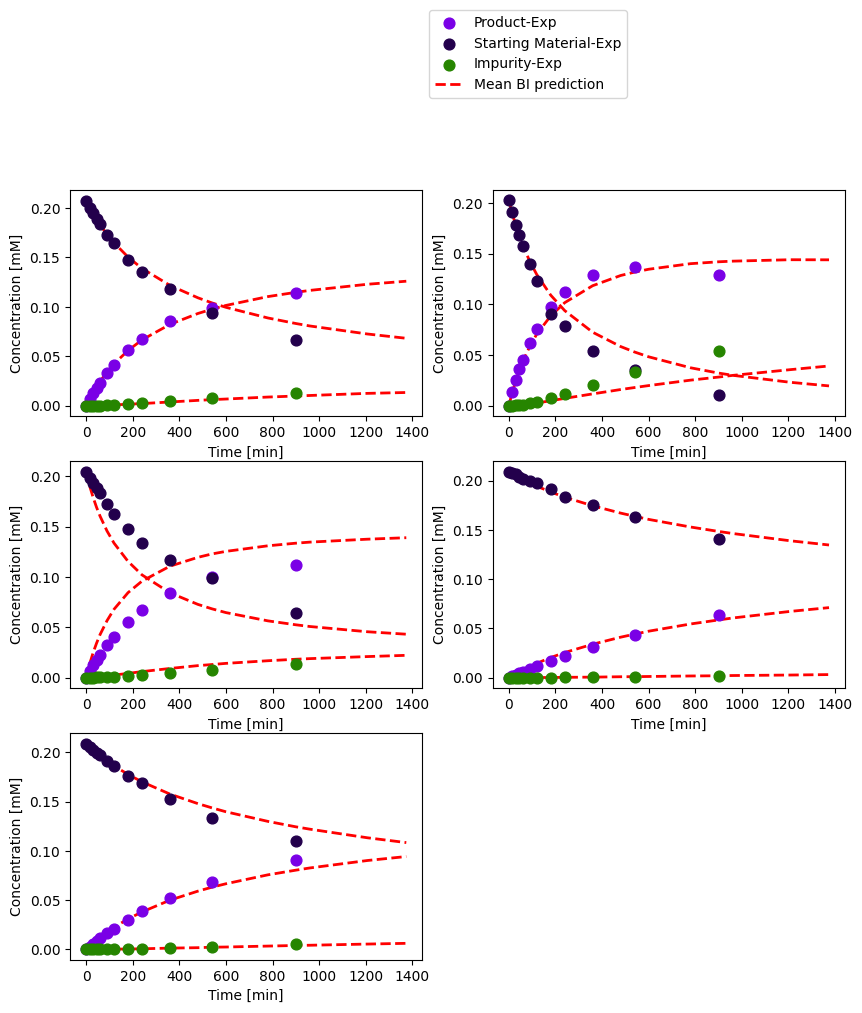

In [256]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    # plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')
    # plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')
    # plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')
    # print("Impurity: ", C_out[-1, i, 4])
    # print("Product: ", C_out[-1, i, 3])
    print("Difference: ", float(C_out[-1, i, 3] - C_out[-1,i,4]))
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[1],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
mean_predicted = []
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    # for j in range(300):
    #     plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
    #     plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
    #     plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(len(y_predicted_all))], axis=0)


    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')



    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


In [188]:
hmc_samples = BI_model.get_samples().items()
def summary(samples):
    site_stats = {}
    for site_name, values in samples:
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: E1_f
        mean       std        5%        25%        50%        75%        95%
0  11.133801  0.970318  9.568366  10.494024  11.120966  11.783592  12.751753 

Site: E2_f
        mean       std       5%        25%        50%        75%        95%
0  11.164776  1.005874  9.52984  10.483469  11.139107  11.862221  12.803187 

Site: k1_f
       mean       std        5%       25%       50%       75%       95%
0  4.405966  0.041613  4.351008  4.385074  4.404036  4.424098  4.460266 

Site: k2_f
       mean       std       5%       25%       50%       75%       95%
0  6.008748  0.278674  5.86241  5.943253  5.989173  6.035878  6.128057 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.003019  0.001565  0.001657  0.002152  0.002659  0.003421  0.005241 



In [51]:
import jax.numpy as jnp

site_stats = summary(hmc_samples)
exp_means = {}
for site, stats in site_stats.items():
    if site == "sigma":
        continue  # skip sigma
    
    mean = stats.loc[0, "mean"]
    
    if site.startswith("k"):  # apply negative exponent to k values
        exp_means[site] = jnp.exp(-mean)
    else:
        exp_means[site] = jnp.exp(mean)

print(exp_means)

{'E1_f': Array(69483.05, dtype=float32), 'E2_f': Array(72597.04, dtype=float32), 'k1_f': Array(0.01435824, dtype=float32), 'k2_f': Array(0.00064834, dtype=float32)}


In [52]:
mean_predicted = np.mean([y_predicted_all[j] for j in range(len(y_predicted_all))], axis=0)
print(mean_predicted[-1,0,3])
# print(mean_predicted)
print(C_out[-1,0,3])

0.14417244
0.12931755


In [63]:
exp_means = {
    "k1_f": 0.012,
    "E1_f": 67420.656,
    "k2_f": 0.002,
    "E2_f": 70459.555
}

In [ ]:
from skopt import Optimizer
import math

def objective(x):  # x = [temperature, init_SM, init_reagent, init_base, ...]
    # Run the simulation
    # C_out, names = reaction1_1.simulate_symbolic_ode_(x, ground_truth_params, time, initial_species)
    C_out, names = reaction1_1.simulate_symbolic_ode_(x, exp_means, time, initial_species)
    final_product_conc = C_out[-1,0,3]
    impurity = jnp.sum(C_out[-1,0,4:])
    total_conc = jnp.sum(C_out[-1, 0])

    if total_conc > 0 and (impurity / total_conc) >= 0.05:
        print("here")
        return 1e6
    
    
    loss = -final_product_conc + impurity
    if math.isnan(loss):
        print(x)
        print(C_out)
    # Return negative to maximize (BO minimizes by default)
    return float(loss)


In [71]:
# search_space = [
#     (50, 120.0),   # Temperature (°C)
#     (0.0, 0.209),      # Initial [SM]
#     (0.0, 0.4),      # Initial [Reagent]
#     (0.0, 0.811),      # Initial (base)
# ]

search_space = [
    (50, 120.0),   # Temperature (°C)
    (0.0, 2),      # Initial [SM]
    (0.0, 2),      # Initial [Reagent]
    (0.0, 2),      # Initial (base)
]

opt = Optimizer(search_space, base_estimator='GP', acq_func='EI')

for _ in range(100):
    x_orig = opt.ask()
    x = jnp.array(x_orig)
    x_with_zero = jnp.append(x, 0)
    x = x_with_zero[None, :]
    y = objective(x)
    opt.tell(x_orig, y)

best_input = opt.Xi[np.argmin(opt.yi)]
best_output = -min(opt.yi)  # max product


here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [73]:
x = best_input
# x = [68.8, 2, 1, 2]
x = jnp.array(x)
x_with_zero = jnp.append(x, 0)  # append a 0 to the end
x = x_with_zero[None, :]
C_out, names = reaction1_1.simulate_symbolic_ode_(x, exp_means, time, initial_species)
base_final_product = C_out[-1, 0, 3]
impurity = C_out[-1, 0, 4]
total_conc = jnp.sum(C_out[-1, 0])


print("Best input:", best_input)
print("Final product concentration:", base_final_product)
print("Final impurity concentration:", impurity)
print("Difference: ", base_final_product - impurity)
print("Total conc: ", total_conc)
print("Percentage: ", 100*(impurity/total_conc), "%")

Best input: [86.49470524143301, 2.0, 0.9957727253451859, 2.0]
Final product concentration: 0.88794196
Final impurity concentration: 0.05391548
Difference:  0.83402646
Total conc:  3.0042276
Percentage:  1.7946535 %


In [ ]:
for i in range(x.shape[1]):
    x_modified = x.at[0, i].set(0)  # set element at row 0, column i to 0

    C_out_mod, _ = reaction1_1.simulate_symbolic_ode_(
        x_modified, ground_truth_params, time, initial_species
    )
    
    modified_product = C_out_mod[-1, 0, 3]
    diff = modified_product - base_final_product

    print(f"Set x[0, {i}] = 0 --> Final product: {modified_product:.4f} | difference = {diff:.4f}")

Set x[0, 0] = 0 --> Final product: 0.0010 | difference = -0.1584
Set x[0, 1] = 0 --> Final product: 0.0000 | difference = -0.1594
Set x[0, 2] = 0 --> Final product: 0.0000 | difference = -0.1594
Set x[0, 3] = 0 --> Final product: 0.1431 | difference = -0.0163
Set x[0, 4] = 0 --> Final product: 0.1431 | difference = -0.0163


In [ ]:
epsilon = 1e-4  # small perturbation

base_output = base_final_product  # From the original full simulation

for i in range(x.shape[1]):
    x_plus = x.at[0, i].set(x[0, i] + epsilon)
    x_minus = x.at[0, i].set(x[0, i] - epsilon)

    C_plus, _ = reaction1_1.simulate_symbolic_ode_(x_plus, exp_means, time, initial_species)
    C_minus, _ = reaction1_1.simulate_symbolic_ode_(x_minus, exp_means, time, initial_species)

    product_plus = C_plus[-1, 0, 3]
    product_minus = C_minus[-1, 0, 3]

    derivative = (product_plus - product_minus) / (2 * epsilon)
    relative_sensitivity = (derivative * x[0, i]) / base_output

    print(f"dProduct/dParam = {derivative:.4f} | Relative sensitivity = {relative_sensitivity:.4f}\n")


dProduct/dParam = 0.0020 | Relative sensitivity = 0.9608

dProduct/dParam = 0.6881 | Relative sensitivity = 1.0252

dProduct/dParam = 0.0939 | Relative sensitivity = 0.2677

dProduct/dParam = 0.0004 | Relative sensitivity = 0.0021

dProduct/dParam = 0.8234 | Relative sensitivity = 0.0000



In [ ]:
reaction1_1.initilize_ODE_solver_for_numpyro_input(x, time, initial_species, [0.1,0,0,0.8,0.1])
y_predicted_all = BI_reaction1.bayesian_inference_predict(BI_model,
                                        function = reaction1_1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors3,
                                        X= x,
                                        num_samples=2000,
                                        num_warmup=1000)

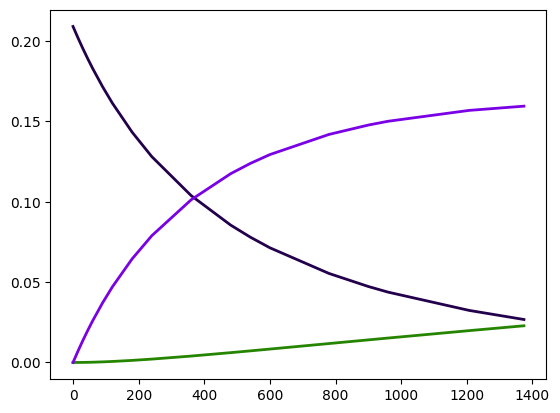

In [ ]:
plt.plot(time, C_out[:, 0, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')
plt.plot(time, C_out[:, 0, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')
plt.plot(time, C_out[:, 0, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')

# for j in range(300):
#     plt.plot(time, y_predicted_all[j][:, 0, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#     plt.plot(time, y_predicted_all[j][:, 0, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     plt.plot(time, y_predicted_all[j][:, 0, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
# mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(len(y_predicted_all))], axis=0)


# plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
# plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
# plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')

In [ ]:
hmc_samples_array = np.array([hmc_samples[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]]).T

ground_truth_array = np.array([ground_truth_params[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]])

figure = corner.corner(
    hmc_samples_array,
    labels=["E1_f", "E2_f", "k1_f", "k2_f"],
    range=[(9,12), (9, 12), (4.2, 4.7), (5, 7)], 
    color='purple',
    truths=ground_truth_array,
    truth_color="Green"
)

TypeError: 'dict_items' object is not subscriptable

In [9]:
import threading
import time

def slow_function(name, iterations=20, delay=1):
    print(f"Starting slow function for {name}...")
    for i in range(iterations):
        if getattr(threading.current_thread(), "do_run", True):
            print(f"Working on {name}... {i}")
            time.sleep(delay)
        else:
            print(f"Thread stopping for {name}...")
            return None
    print(f"Function completed for {name}!")
    return f"Done with {name}"

def run_with_timeout(func, timeout, *args, **kwargs):
    print(f"Starting function with {timeout} second timeout...")
    
    result = [None]  # Use list to store result from thread
    
    def target():
        result[0] = func(*args, **kwargs)
    
    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)
    
    if thread.is_alive():
        print("Timeout! Stopping thread...")
        thread.do_run = False
        thread.join(2)  # Wait a bit more for cleanup
        return None
    return result[0]

# Usage examples:
result1 = run_with_timeout(slow_function, 5, "Task1")
print(f"Result: {result1}")

result2 = run_with_timeout(slow_function, 5, "Task2", iterations=10, delay=0.5)
print(f"Result: {result2}")

result3 = run_with_timeout(slow_function, 5, name="Task3", iterations=30, delay=1)
print(f"Result: {result3}")

Starting function with 5 second timeout...
Starting slow function for Task1...
Working on Task1... 0
Working on Task1... 1
Working on Task1... 2
Working on Task1... 3
Working on Task1... 4
Timeout! Stopping thread...
Thread stopping for Task1...
Result: None
Starting function with 5 second timeout...
Starting slow function for Task2...
Working on Task2... 0
Working on Task2... 1
Working on Task2... 2
Working on Task2... 3
Working on Task2... 4
Working on Task2... 5
Working on Task2... 6
Working on Task2... 7
Working on Task2... 8
Working on Task2... 9
Timeout! Stopping thread...
Function completed for Task2!
Result: None
Starting function with 5 second timeout...
Starting slow function for Task3...
Working on Task3... 0
Working on Task3... 1
Working on Task3... 2
Working on Task3... 3
Working on Task3... 4
Working on Task3... 5
Timeout! Stopping thread...
Thread stopping for Task3...
Result: None
